In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250526.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df['Other'].fillna(method='ffill', inplace=True)


In [35]:
series = df['Local Route']

Q1 = series.quantile(0.25)
Q3 = series.quantile(0.75)
IQR = Q3 - Q1
median = series.median()
series = series.apply(lambda x: median if x < Q1 - 1.5 * IQR or x > Q3 + 1.5 * IQR else x)

In [36]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))


In [37]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 7):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + 7])  # predict next 7 days
    return np.array(X), np.array(y)

In [38]:
window_size = 30
X, y = create_sequences(scaled_data, window_size)

In [39]:
X_train, y_train = X[:-1], y[:-1]

In [40]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(7)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)


Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.1900
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0681
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0643
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0574
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0394
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0284
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0221
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0198
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0203
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0176
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0174
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0167
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0160
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0158
Epoch 15/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s

In [42]:
last_sequence = scaled_data[-window_size:]
last_sequence = last_sequence.reshape((1, window_size, 1))
forecast_scaled = model.predict(last_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


In [43]:
forecast = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()

last_date = df.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7)


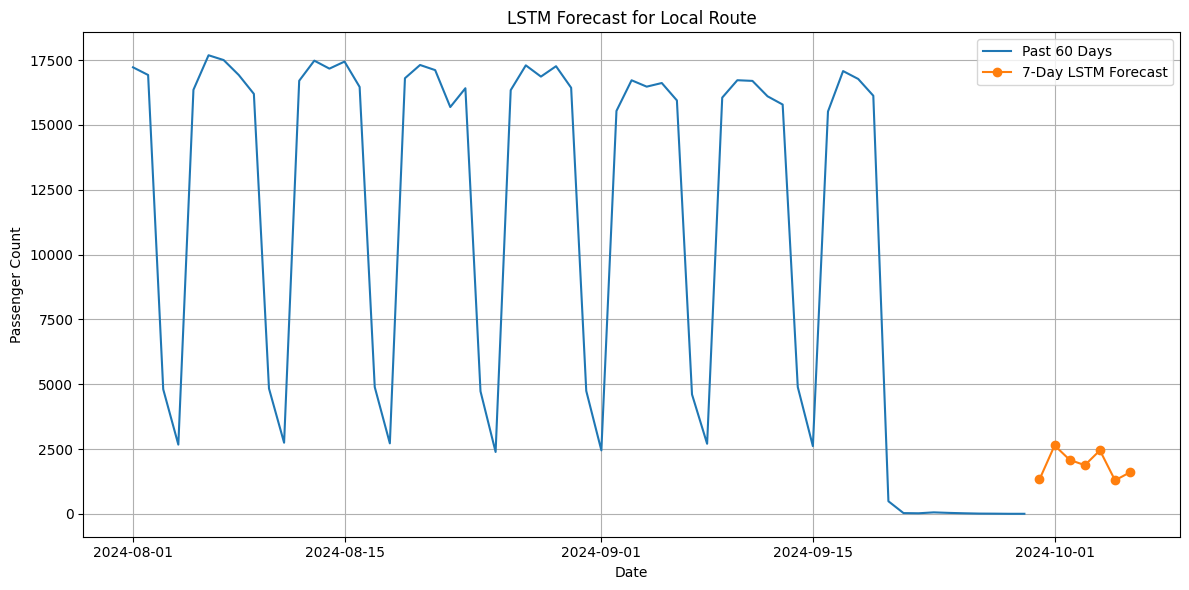

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-60:], df['Local Route'][-60:], label='Past 60 Days')
plt.plot(forecast_dates, forecast, label='7-Day LSTM Forecast', marker='o')
plt.title('LSTM Forecast for Local Route')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Local Route': forecast})
print(forecast_df)

        Date  Forecasted Local Route
0 2024-09-30             1325.811890
1 2024-10-01             2637.760742
2 2024-10-02             2080.965820
3 2024-10-03             1876.684570
4 2024-10-04             2448.440430
5 2024-10-05             1291.829834
6 2024-10-06             1603.764160
